In [6]:
import pandas as pd
import numpy as np
import collections
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings(action = 'once')

In [13]:
path = "C:/Users/Daoyang Shan/Desktop/1001 Cars/autos.csv"
data = pd.read_csv(path, sep = ',', header = 0, encoding = 'cp1252')

del_var=['dateCrawled', 'name', 'offerType', 'abtest', 'monthOfRegistration', 
         'brand', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen']

data = data.drop(labels = del_var,axis = 1)

In [14]:
data = data[(data['price'] > 100) & (data['price'] < 150000) &
            (data['yearOfRegistration'] > 1950) & (data['yearOfRegistration'] < 2017) &
            (data['powerPS'] > 10) & (data['powerPS'] < 500)]

data = data.replace(np.nan,'notDeclared')

In [15]:
# Simulate the process of adding on new data 
all_train, test = train_test_split(data, test_size = 0.2)
train, add_on = train_test_split(all_train, test_size = 0.4)
batches = np.array_split(add_on, 12)

# Handle rare models in the original train set
model_counter = collections.defaultdict(int)
model_counter['andere'] = 101
rare_models = set()
s1 = train['model'].value_counts()

for model in list(s1.index):
    model_counter[model] += s1.loc[model]
    if s1[model] < 100:
        rare_models.add(model)

def partial_convert(c, rare_models, model_counter):
    if c['model'] in rare_models or c['model'] not in model_counter:
        return 'rareModel'
    return c['model']

partial_func = partial(partial_convert, rare_models = rare_models, model_counter = model_counter)
train['modifiedModel'] = train.apply(partial_func, axis = 1)

counter_copy = model_counter.copy()
rare_models_copy = rare_models.copy()

C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
# If we simulate a real world scenario in which we test on first batch, then combine original train set and batch 1 and test on
# batch 2, and so on, what will happen?

mae_dynamic = []
train1 = train.copy()

# Add batches to the previous train data, update rare_list, retrain model
for i in range(12):
    cur_batch = batches[i]
    cur_batch['modifiedModel'] = cur_batch.apply(partial_func, axis = 1)
    cur_batch_size = cur_batch.shape[0]
    
    # Concat original train data and batch, dummify, and seperate
    temp = pd.concat([train1, cur_batch], ignore_index = True).drop(['model'], axis = 1)
    cat_list = list(temp.columns[temp.dtypes == object])
    temp_withdummies = pd.get_dummies(temp, columns = cat_list)
    
    batch_withdummies = temp_withdummies.tail(cur_batch_size)
    train_withdummies = temp_withdummies.iloc[:-cur_batch_size]
    
    # Train_Test split, train model
    twd_Y = train_withdummies['price']
    twd_X = train_withdummies.drop('price', axis = 1)
    bwd_Y = batch_withdummies['price']
    bwd_X = batch_withdummies.drop('price', axis = 1)
    
    rf = RandomForestRegressor()
    rf.fit(twd_X, twd_Y)
    pred = rf.predict(bwd_X)
    cur_mae = mean_absolute_error(bwd_Y, pred)
    mae_dynamic.append(cur_mae)
    print ('batches added: {}'.format(i + 1))
    
    # Now, update rare model list and combine data
    si = cur_batch['model'].value_counts()

    for model in list(si.index):
        model_counter[model] += si.loc[model]
        if (model_counter[model] >= 100) and (model in rare_models):
            rare_models.remove(model)
        if (model_counter[model] < 100) and (model not in rare_models):
            rare_models.add(model)
    
    train1.drop('modifiedModel', axis = 1, inplace = True)
    train1 = pd.concat([train1, cur_batch], ignore_index = True)
    train1['modifiedModel'] = train1.apply(partial_func, axis = 1)

batches added: 1
batches added: 2
batches added: 3
batches added: 4
batches added: 5
batches added: 6
batches added: 7
batches added: 8
batches added: 9
batches added: 10
batches added: 11
batches added: 12


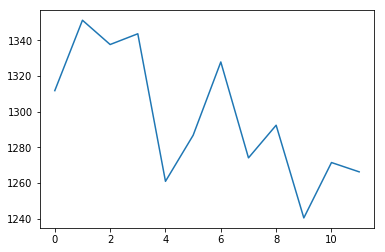

In [20]:
plt.figure()
plt.plot(mae_dynamic)
plt.savefig('dynamic.png')
plt.show()

In [18]:
# Keep the procee we simulated above, but this time we only train on the fixed train set. Ideally we should get better 
# model with more data added. Is this true in practice?

mae_static = []
train2 = train.copy()
test_size = test.shape[0]

# Reset model counter and the set of rare models
model_counter = counter_copy
rare_models = rare_models_copy

# Add batches to the previous train data, update rare_list, retrain model
for i in range(12):
    cur_batch = batches[i]
    cur_batch['modifiedModel'] = cur_batch.apply(partial_func, axis = 1)
    test['modifiedModel'] = test.apply(partial_func, axis = 1)
    
    # Concat original train data, batch and test set, dummify, and seperate
    temp = pd.concat([train2, cur_batch, test], ignore_index = True).drop(['model'], axis = 1)
    cat_list = list(temp.columns[temp.dtypes == object])
    temp_withdummies = pd.get_dummies(temp, columns = cat_list)
    
    test_withdummies = temp_withdummies.tail(test_size)
    train_withdummies = temp_withdummies.iloc[:-test_size]
    
    # Train_Test split, train model
    trnwd_Y = train_withdummies['price']
    trnwd_X = train_withdummies.drop('price', axis = 1)
    tstwd_Y = test_withdummies['price']
    tstwd_X = test_withdummies.drop('price', axis = 1)
    
    rf = RandomForestRegressor()
    rf.fit(trnwd_X, trnwd_Y)
    pred = rf.predict(tstwd_X)
    cur_mae = mean_absolute_error(tstwd_Y, pred)
    mae_static.append(cur_mae)
    print ('batches added: {}'.format(i + 1))
    
    # Now, update rare model list and combine data
    si = cur_batch['model'].value_counts()

    for model in list(si.index):
        model_counter[model] += si.loc[model]
        if (model_counter[model] >= 100) and (model in rare_models):
            rare_models.remove(model)
        if (model_counter[model] < 100) and (model not in rare_models):
            rare_models.add(model)
    
    train2.drop('modifiedModel', axis = 1, inplace = True)
    train2 = pd.concat([train2, cur_batch], ignore_index = True)
    train2['modifiedModel'] = train2.apply(partial_func, axis = 1)
    test.drop('modifiedModel', axis = 1, inplace = True)

C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


batches added: 1


C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


batches added: 2


C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


batches added: 3


C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


batches added: 4


C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


batches added: 5


C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


batches added: 6


C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


batches added: 7


C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


batches added: 8


C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


batches added: 9


C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


batches added: 10


C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


batches added: 11


C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


batches added: 12


C:\Users\Daoyang Shan\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


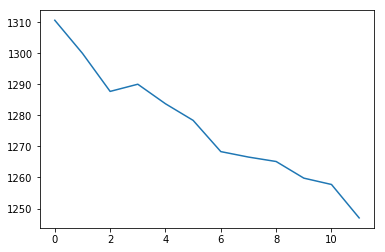

In [21]:
plt.figure()
plt.plot(mae_static)
plt.savefig('static.png')
plt.show()